(mmm_sensitivity_analysis)=
# Understanding your MMM: Sensitivity Analysis and Marginal Effects

Extracting insights to drive business decisions is a primary goal of any MMM. PyMC-Marketing already offers a powerful suite of tools for this, including:

* Driver contributions: Understanding how much each channel or factor is contributing to the outcome.
* Return on Ad Spend (ROAS): Quantifying the financial return of your media investments.
* Saturation curves: Visualizing how the impact of media spend changes at different spend levels (e.g., diminishing returns).

However, in many real-world cases, we want to go beyond these summaries. Marketers and analysts frequently ask:
	
* "What would have happened if we had spent 10% less on media last month?"
* "What would the effect of lowering the free shipping threshold by $5 have been?"
* "Are we still getting good incremental returns at current spend levels, or have we hit diminishing returns?"

These questions focus on hypothetical scenarios of what would have happened under different conditions. As such, they are a clear form of **[sensitivity analysis](https://en.wikipedia.org/wiki/Sensitivity_analysis)**. Given that we focus on _retrospective_ predictions, these questions are "Step 3" on Pearl's cuasal ladder (see the [MMMs and Pearl's ladder of causal inference](https://www.pymc-marketing.io/en/stable/notebooks/mmm/mmm_counterfactuals.html) docs). The basic idea is that we can use our model (and what it has learned from the data) to simulate how the outcome would have changes under various peterbations of the driver variables.

Rather than just considering a single peterbation (e.g., "what if we had spent 10% less on a given media channel"), sensitivity analysis allows us to explore a range of scenarios. So instead we could evaluate our predictions given a **sweep** of possible peterbations. For example, "what if we had spent [0.5, 0.75, 1.0, 1.25, 2.0] times as much on a given media channel?"

We introduce a flexible tool that allows you to:
	
* Perform counterfactual sweeps across a range of predictor values (e.g., scaling media spend up/down or adjusting business levers like pricing),
* Visualize both the total expected impact of these interventions,
* And compute marginal effects—showing the instantaneous rate of change in the outcome as you adjust a predictor.

This approach complements the built-in PyMC-Marketing tools by providing scenario-based insights that help you answer "what if" questions with precision and clarity.

## Setting the scene with an example dataset

In this example, we model weekly sales for a direct-to-consumer (DTC) brand that invests in influencer marketing while also adjusting its free shipping policy to drive conversions. 

Our media variable is **Influencer Spend**, which typically exhibits non-linear effects due to factors like audience saturation and delayed impact, making it a good candidate for adstock and saturation transformations. 

As a control variable, we include the **Free Shipping Threshold** — the minimum order value required for customers to qualify for free shipping. This is a fully controllable business lever and is expected to have a more linear relationship with sales: lowering the threshold generally increases conversion rates in a predictable way. 

By examining the marginal effects of media spend and shipping policy, we can provide actionable insights into how each lever contributes to overall performance.

In [1]:
import warnings

import arviz as az
import graphviz as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pymc_marketing.mmm import (
    GeometricAdstock,
    LogisticSaturation,
)
from pymc_marketing.mmm.multidimensional import MMM
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation

warnings.filterwarnings("ignore", category=FutureWarning)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

seed: int = sum(map(ord, "ladder"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

/Users/benjamv/mambaforge/envs/pymc-marketing-dev/lib/python3.10/site-packages/pymc_marketing/mmm/multidimensional.py:68: FutureWarning: This functionality is experimental and subject to change. If you encounter any issues or have suggestions, please raise them at: https://github.com/pymc-labs/pymc-marketing/issues/new
  warnings.warn(warning_msg, FutureWarning, stacklevel=1)


So our causal MMM will look like this:

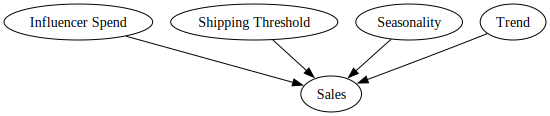

In [2]:
g = gr.Digraph()

g.node(name="Sales", label="Sales")
g.node(name="Influencer Spend", label="Influencer Spend")
g.node(name="Shipping Threshold", label="Shipping Threshold")
g.node(name="Seasonality", label="Seasonality")
g.node(name="Trend", label="Trend")

g.edge(tail_name="Influencer Spend", head_name="Sales")
g.edge(tail_name="Shipping Threshold", head_name="Sales")
g.edge(tail_name="Seasonality", head_name="Sales")
g.edge(tail_name="Trend", head_name="Sales")
g

## Why Marginal Effects Matter: going beyond raw media curves

In Media Mix Models (MMM), we're often interested in understanding how each marketing input—like advertising spend—drives business outcomes. A common way to explore this is by looking at the inferred response curves, such as the saturation curve for media spend. These curves show how total sales respond to increasing investment, accounting for effects like diminishing returns and adstock.

But while these plots are useful, they can be misleading or incomplete when used in isolation.

The reason? Response curves tell you the absolute level of impact across different spend amounts, but they don’t directly tell you the incremental impact of a small change in spend at any given point. This distinction is crucial. For example:
	
* A saturation curve might look steep at low spend levels and flatten out at higher spend—but the exact slope at a specific point (e.g., \$50,000 per week) tells you the real-world payoff of spending an extra \$1,000 right now.
* In cases where multiple inputs are at play (like media spend and pricing changes), response curves for one variable don't show you how interactions or current levels of other variables might affect its marginal impact.

Marginal effects zero in on this slope—the instantaneous rate of change. They answer questions like:
	
* How much additional sales do I gain if I increase influencer spend by 10% next week?
* What's the expected lift if I lower the free shipping threshold by \$5 right now?

These insights are only accessible through marginal effects because they reflect the dynamic, context-sensitive responsiveness of the model:
	
* For media inputs with non-linear transformations (like adstock + saturation), marginal effects show how effectiveness varies across the spend range—revealing whether you're still in the high-ROI zone or have hit diminishing returns.
* For controllable non-media levers (like pricing or shipping policies), marginal effects provide precise, actionable estimates for how tweaks to these levers impact outcomes—even if their overall relationship is more linear.

In other words, while a response curve is like a map of the terrain, marginal effects tell you whether it's worth climbing that next hill. They enable surgical precision in decision-making, ensuring that marketers don't just see where their efforts sit on a curve—but understand whether pushing harder in a particular direction is still worthwhile.

By incorporating marginal effects into MMM outputs, we move from a static understanding of media performance to a dynamic, context-aware view that directly informs resource allocation and strategic adjustments.

## Generate simulated data

In [3]:
def apply_transformations(df, channel, alpha, lam):
    """Apply geometric adstock and saturation transformations."""
    adstocked = geometric_adstock(
        x=df[channel].to_numpy(), alpha=alpha, l_max=8, normalize=True
    ).eval()

    saturated = logistic_saturation(x=adstocked, lam=lam).eval()
    return saturated


def forward_pass(df_in, params):
    """Run predictor variables through the forward pass of the model.

    Given a dataframe with spend data columns and control variables, run this through the
    transformations and return the response variable `y`.
    """
    df = df_in.copy()

    # Apply transformations to channels and calculate y
    df["y"] = params["amplitude"] * (
        df["intercept"]
        + df["trend"]
        + df["seasonality"]
        + sum(
            params["beta"][i]
            * apply_transformations(
                df, params["channels"][i], params["alpha"][i], params["lam"][i]
            )
            for i in range(len(params["channels"]))
        )
        + params["gamma"] * df["shipping_threshold"]  # Include shipping_threshold
        + df["epsilon"]
    )

    return df


df = pd.DataFrame(
    data={
        "date": pd.date_range(
            start=pd.to_datetime("2019-04-01"),
            end=pd.to_datetime("2021-09-01"),
            freq="W-MON",
        )
    }
).assign(
    year=lambda x: x["date"].dt.year,
    month=lambda x: x["date"].dt.month,
    dayofyear=lambda x: x["date"].dt.dayofyear,
    t=lambda x: range(x.shape[0]),
)

n_rows = df.shape[0]

# Media data: influencer spend
influencer_spend = rng.uniform(low=0.0, high=1.0, size=n_rows)
df["influencer_spend"] = np.where(
    influencer_spend > 0.9, influencer_spend, influencer_spend / 2
)

# Control variable: shipping threshold
df["shipping_threshold"] = 25.0
df["shipping_threshold"].iloc[-12:] = (
    20.0  # Reduced shipping threshold in the last 12 weeks
)
# Intercept, trend, seasonality components
df["intercept"] = 2.0
df["trend"] = (np.linspace(start=0.0, stop=50, num=n_rows) + 10) ** (1 / 4) - 1
df["cs"] = -np.sin(2 * 2 * np.pi * df["dayofyear"] / 365.5)
df["cc"] = np.cos(1 * 2 * np.pi * df["dayofyear"] / 365.5)
df["seasonality"] = 0.5 * (df["cs"] + df["cc"])

# Noise - can be considered as the effects of unobserved variables upon sales
df["epsilon"] = rng.normal(loc=0.0, scale=0.25, size=n_rows)

params = {
    "channels": ["influencer_spend"],
    "amplitude": 1.0,
    "beta": [3.0],
    "lam": [4.0],
    "alpha": [0.4],
    "gamma": -0.1,  # Weight for shipping_threshold
}

df = forward_pass(df, params)

/var/folders/pd/p2qnky2x3xl4w3mgc4lct2200000gn/T/ipykernel_27358/2986297912.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["shipping_threshold"].iloc[-12:] = (


And here are the first 5 rows of the synthetic dataset:

In [4]:
df.head()

,date,year,month,dayofyear,t,influencer_spend,shipping_threshold,intercept,trend,cs,cc,seasonality,epsilon,y
0,2019-04-01,2019,4,91,0,0.918883,25.0,2.0,0.778279,-0.012893,0.006446,-0.003223,-0.118826,2.561363
1,2019-04-08,2019,4,98,1,0.230898,25.0,2.0,0.795664,0.225812,-0.113642,0.056085,0.064977,2.264874
2,2019-04-15,2019,4,105,2,0.254486,25.0,2.0,0.812559,0.451500,-0.232087,0.109706,-0.020269,1.998208
3,2019-04-22,2019,4,112,3,0.035995,25.0,2.0,0.828993,0.651162,-0.347175,0.151993,0.400209,1.701116
4,2019-04-29,2019,4,119,4,0.336013,25.0,2.0,0.844997,0.813290,-0.457242,0.178024,0.057609,2.003646


And we can plot the data to get a better sense for the data:

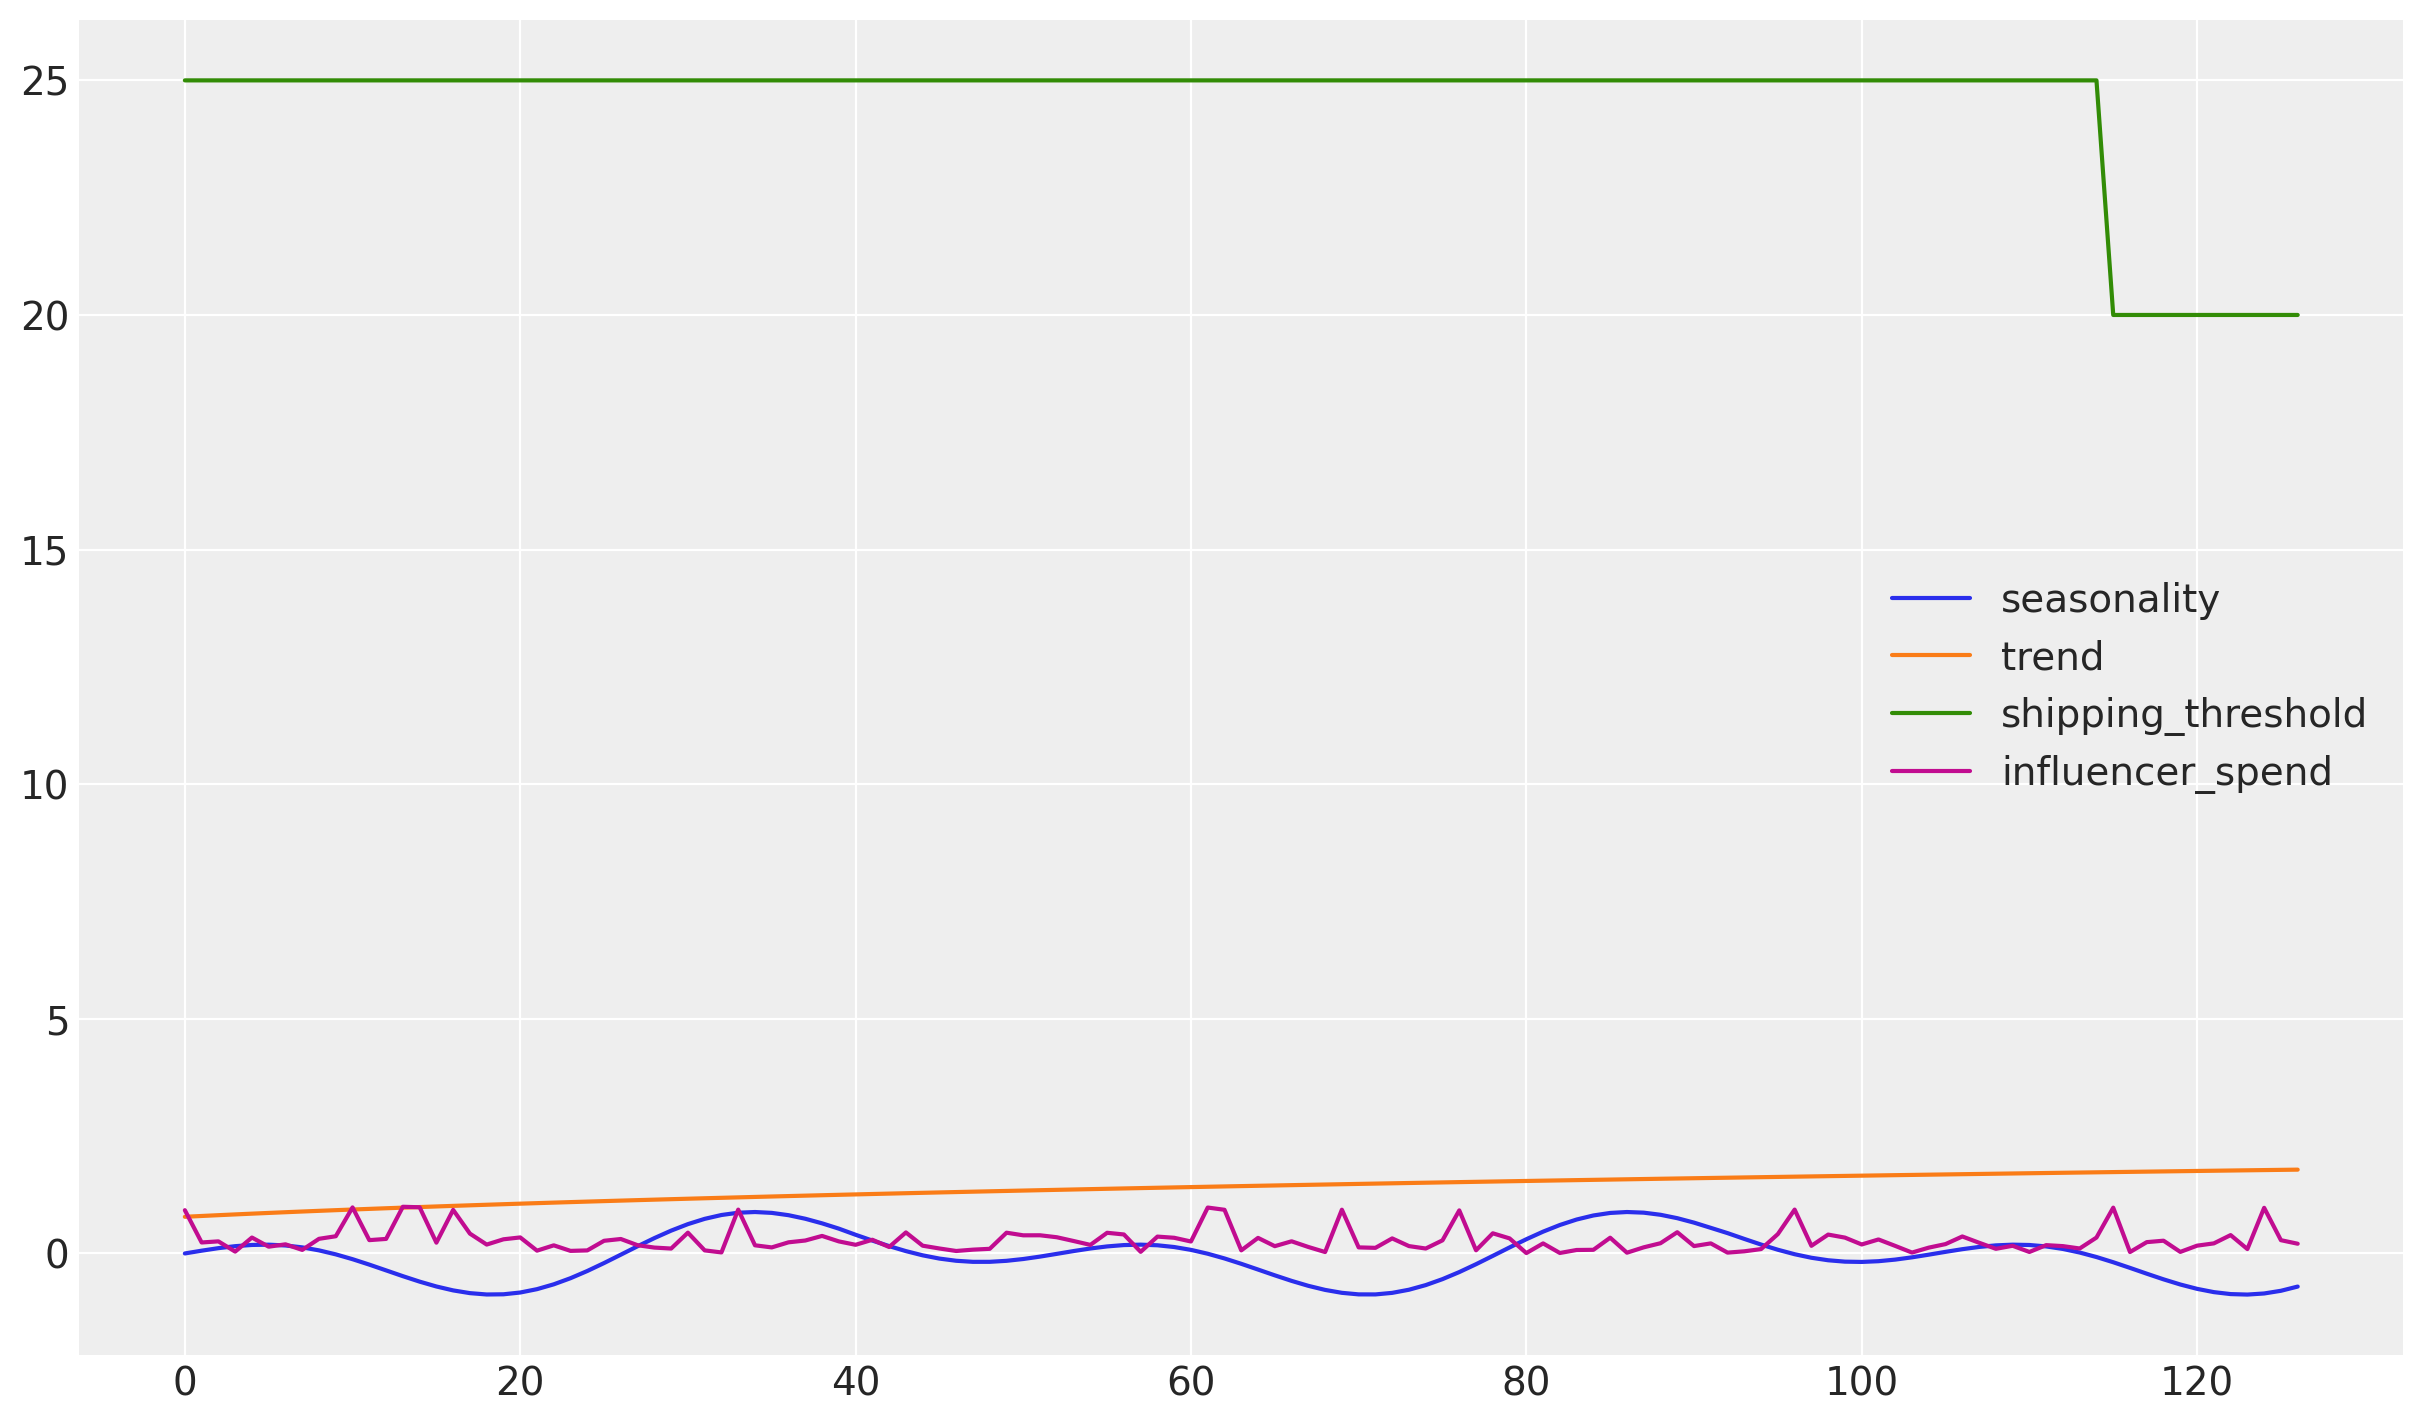

In [5]:
df[["seasonality", "trend", "shipping_threshold", "influencer_spend"]].plot();

## Build and fit the MMM

In [6]:
mmm = MMM(
    date_column="date",
    target_column="y",
    adstock=GeometricAdstock(l_max=8),
    saturation=LogisticSaturation(),
    channel_columns=["influencer_spend"],
    control_columns=["t", "shipping_threshold"],
    yearly_seasonality=2,
)

x_train = df.drop(columns=["y"])
y_train = df["y"]

mmm.fit(X=x_train, y=y_train)
mmm.sample_posterior_predictive(x_train, extend_idata=True);

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_contribution, adstock_alpha, saturation_lam, saturation_beta, gamma_control, gamma_fourier, y_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
Sampling: [y]


Output()

## Sensitivity analysis and marginal effects

### A multiplicative sweep on influencer spend

In [7]:
mmm.sensitivity_analysis(
    predictors=["influencer_spend"],
    sweep_values=np.linspace(0, 2, 12),
    sweep_type="multiplicative",
)

Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]


The code above saves its results into a new group in the `mmm.idata` called `sensitivity_analysis`. You can explore it below:

In [8]:
mmm.idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data
	> posterior_predictive
	> sensitivity_analysis

And of course, you can plot the results!

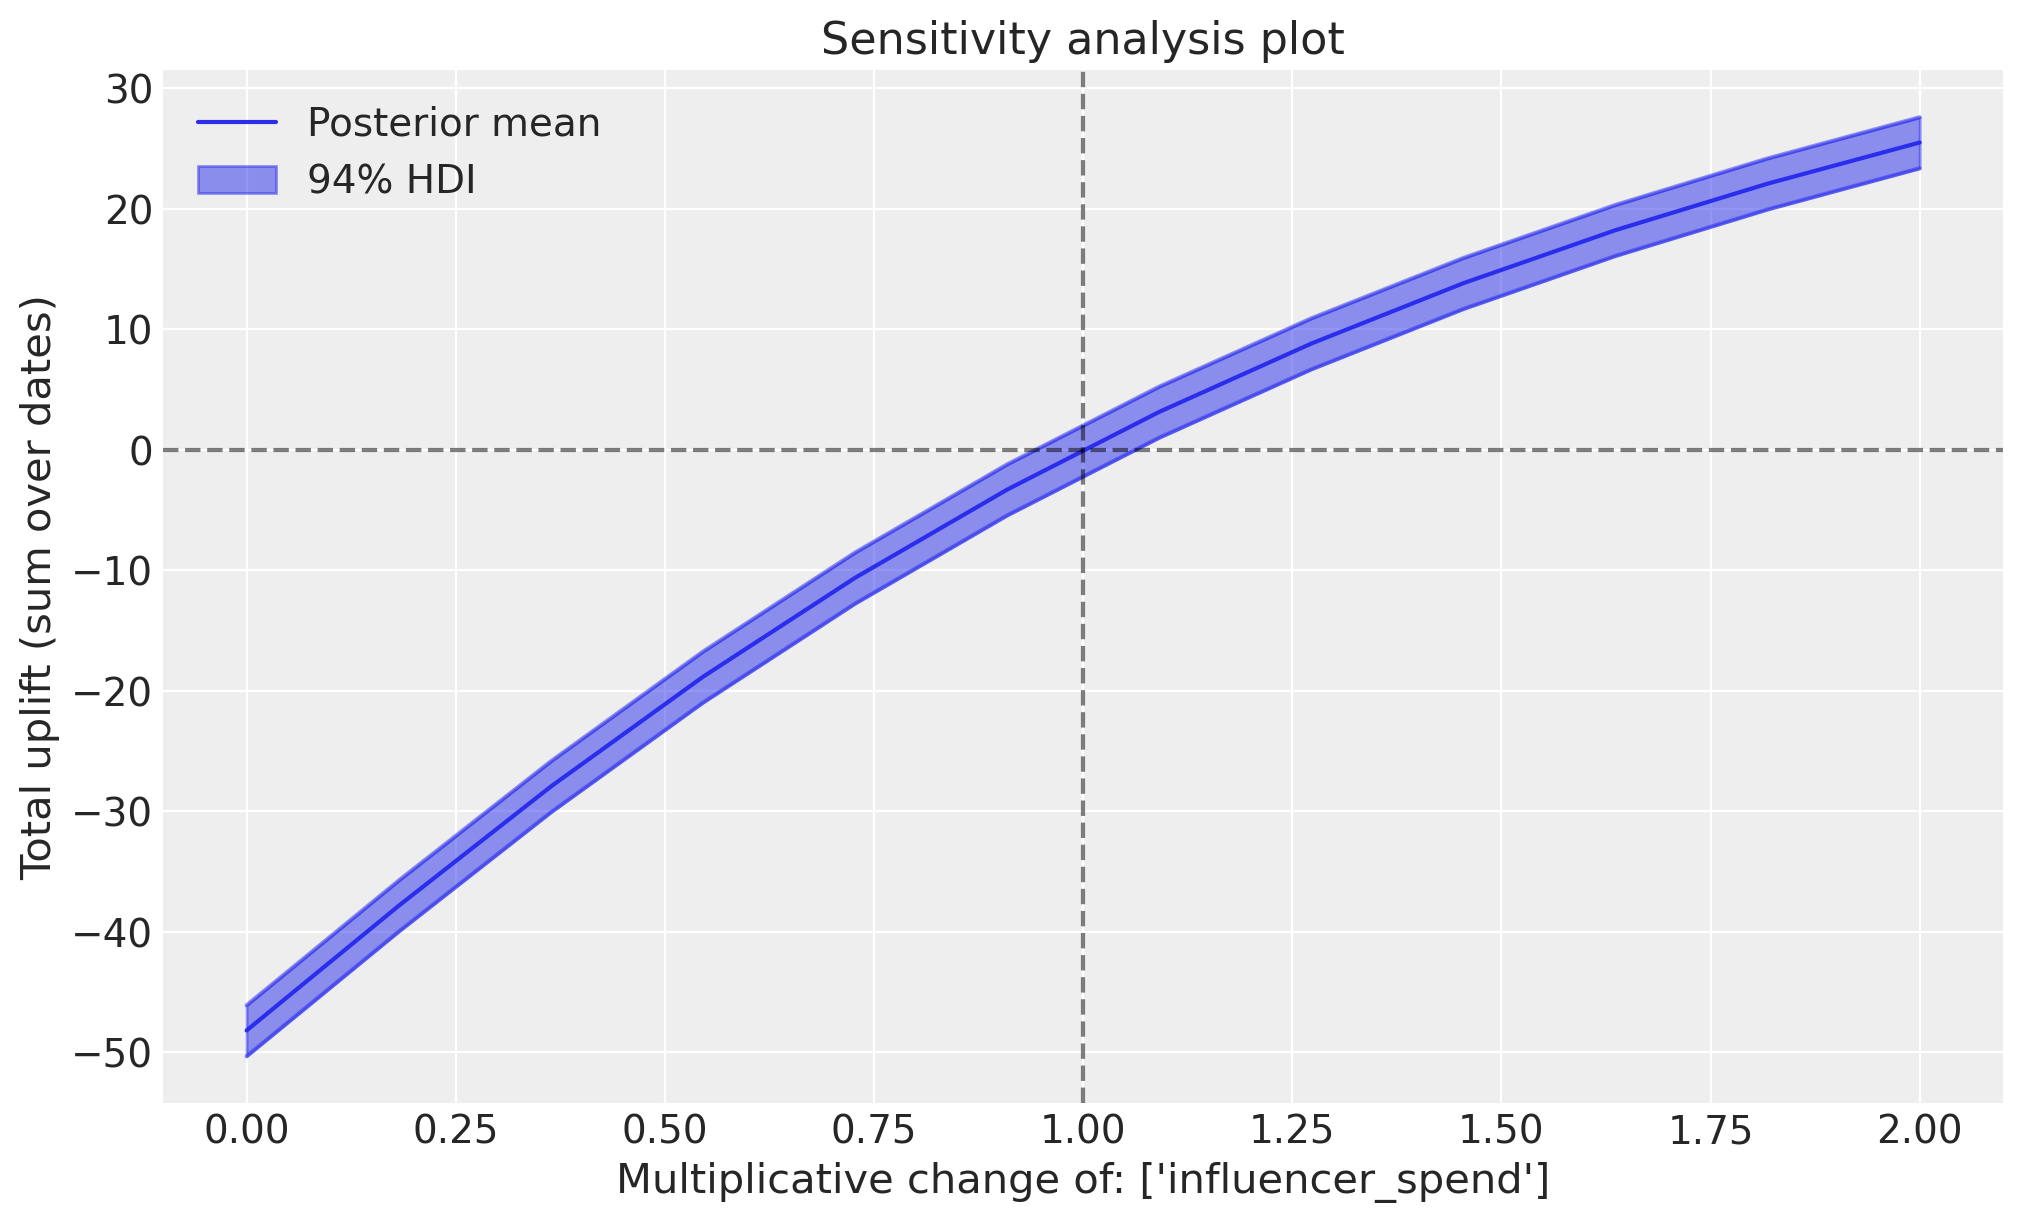

In [9]:
mmm.plot.plot_sensitivity_analysis();

The figure above shows the total expected uplift (it can be positive or negative) for the outcome variable as a function of the sweep values provided. In this case, we used a multiplicative sweep, so the curve is showing how the total outcome would vary if we multiply up (sweep values > 1) or down (sweep values < 1) the influencer spend by the set of values we asked for.

Intuitively, if we multiply the influence spend by 1.0 then on average we expect no change. If we scale the spend down then we expect negative uplift (i.e., lower sales) and if we scale the spend up then we expect positive uplift (i.e., higher sales). The fact that the curve is curved (not linear) is primarily the result of the saturation function on the influencer spend variable.

We can also plot the corresponding marginal effects as below:

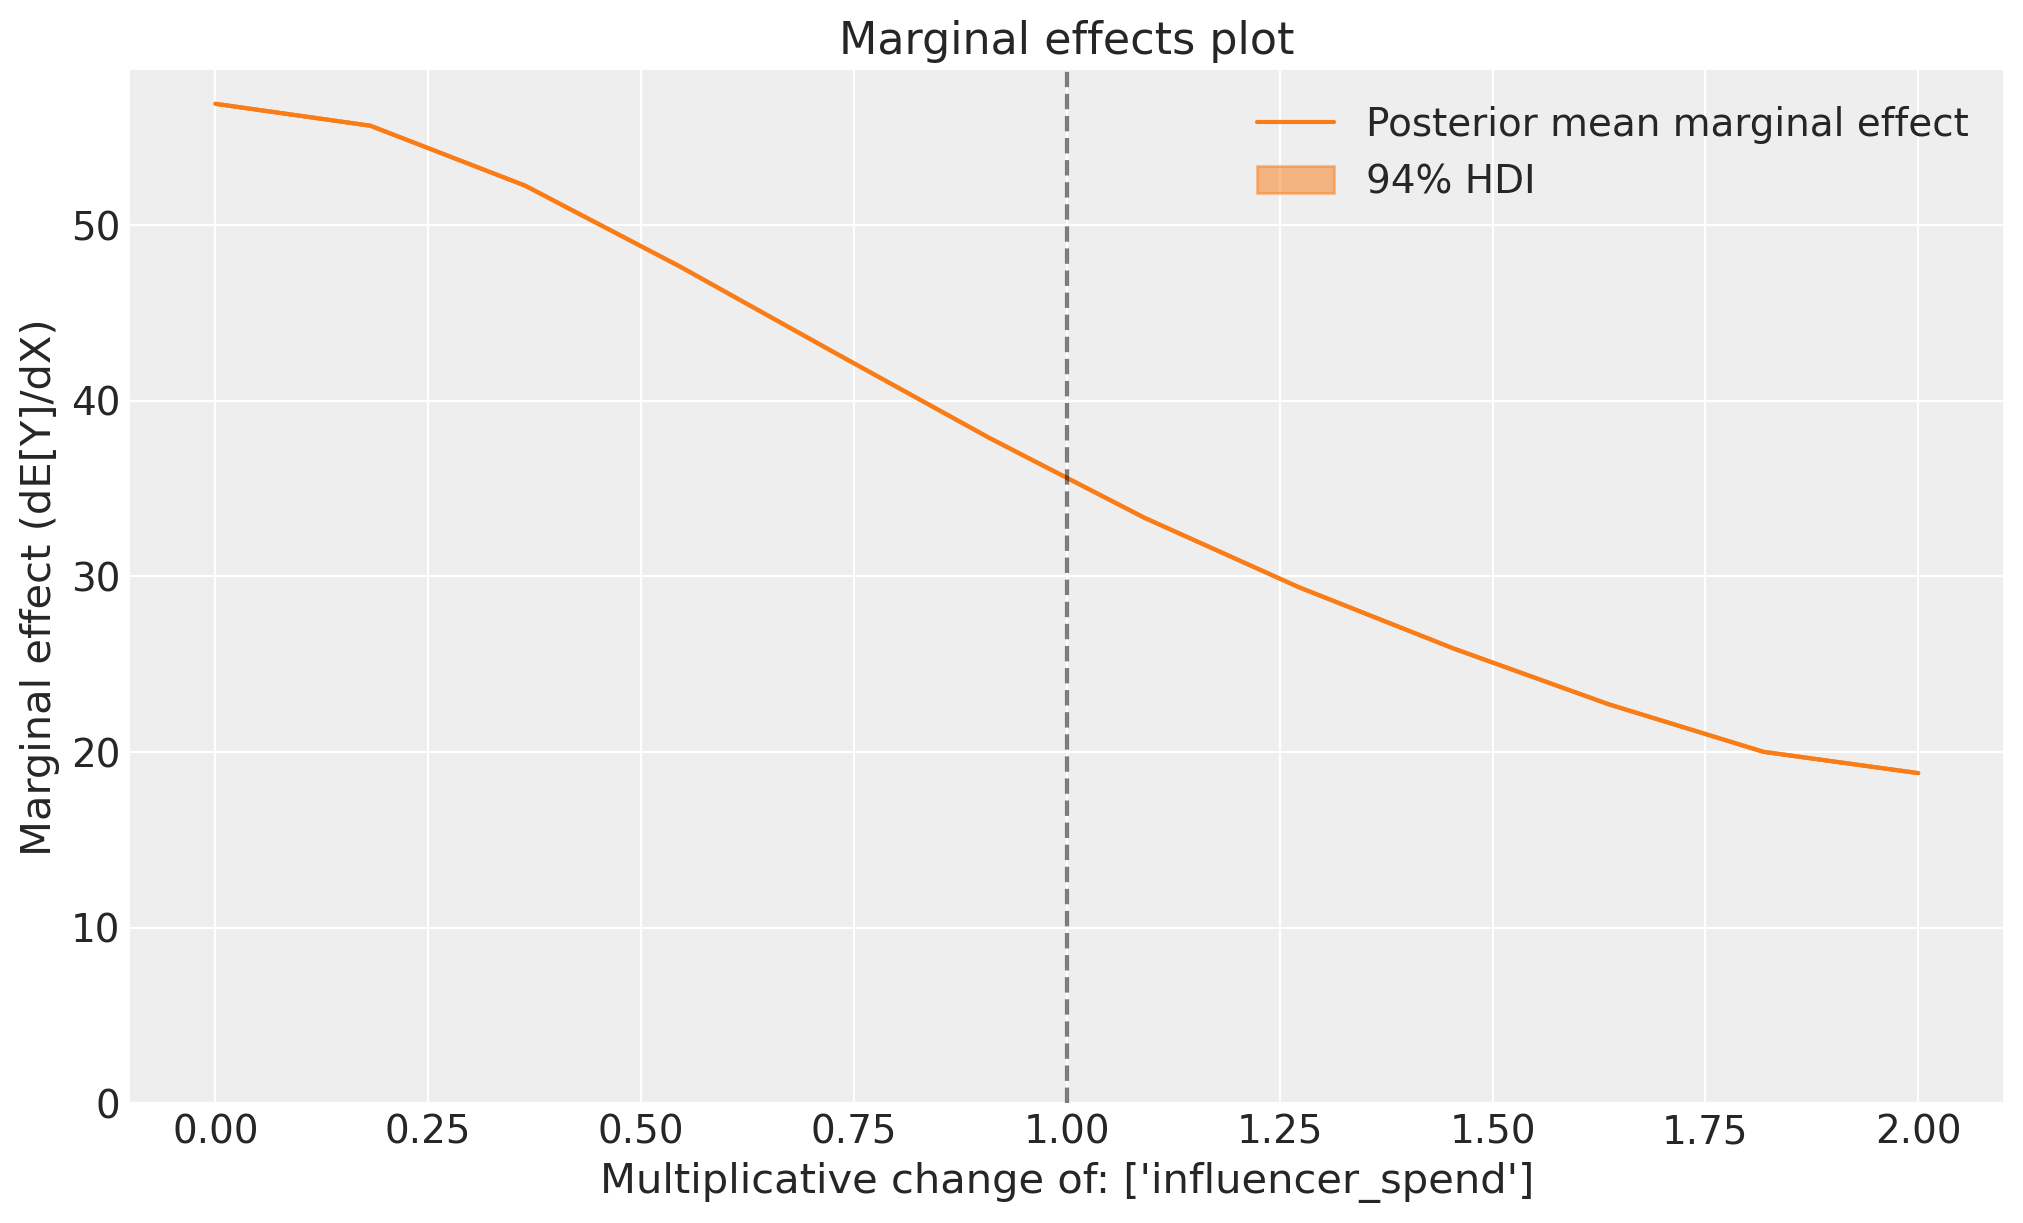

In [10]:
mmm.plot.plot_sensitivity_analysis(marginal=True);

This plot shows the instantaneous rate of change in the outcome variable as we adjust the influencer spend. The y-axis represents the marginal effect, which tells us how much additional sales we expect for a small increase in influencer spend at each point along the sweep values.

We can see that the highest marginal effects occur on the left side of the plot where we the influence spend is zero or very low. The highest incremental/marginal effects are obtained when we go from no spend to some spend. As we would expect from the previous plot, we still get incremental returns at the current spend levels (multiplicative change of 1.0), and are quite far away from totally saturating this channel - the marginal spend doesn't reduce to near zero even if we consider a 2x increase in spend.

### An absolute sweep on influencer spend

The sensitivity analysis we conducted above involved a _multiplicative sweep_ of the influencer spend variable, meaning we varied it by multiplying it by a set of values. However, we can also conduct a _absolute sweep_. Here, we set all historical values of the influencer spend variable to fixe values (given in the `sweep_values` argument) and then compute the expected outcome and marginal effects.

In [11]:
mmm.sensitivity_analysis(
    predictors=["influencer_spend"],
    sweep_values=np.linspace(0, 2, 12),
    sweep_type="absolute",
)

Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]


/Users/benjamv/mambaforge/envs/pymc-marketing-dev/lib/python3.10/site-packages/pymc_marketing/mmm/plot.py:1017: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


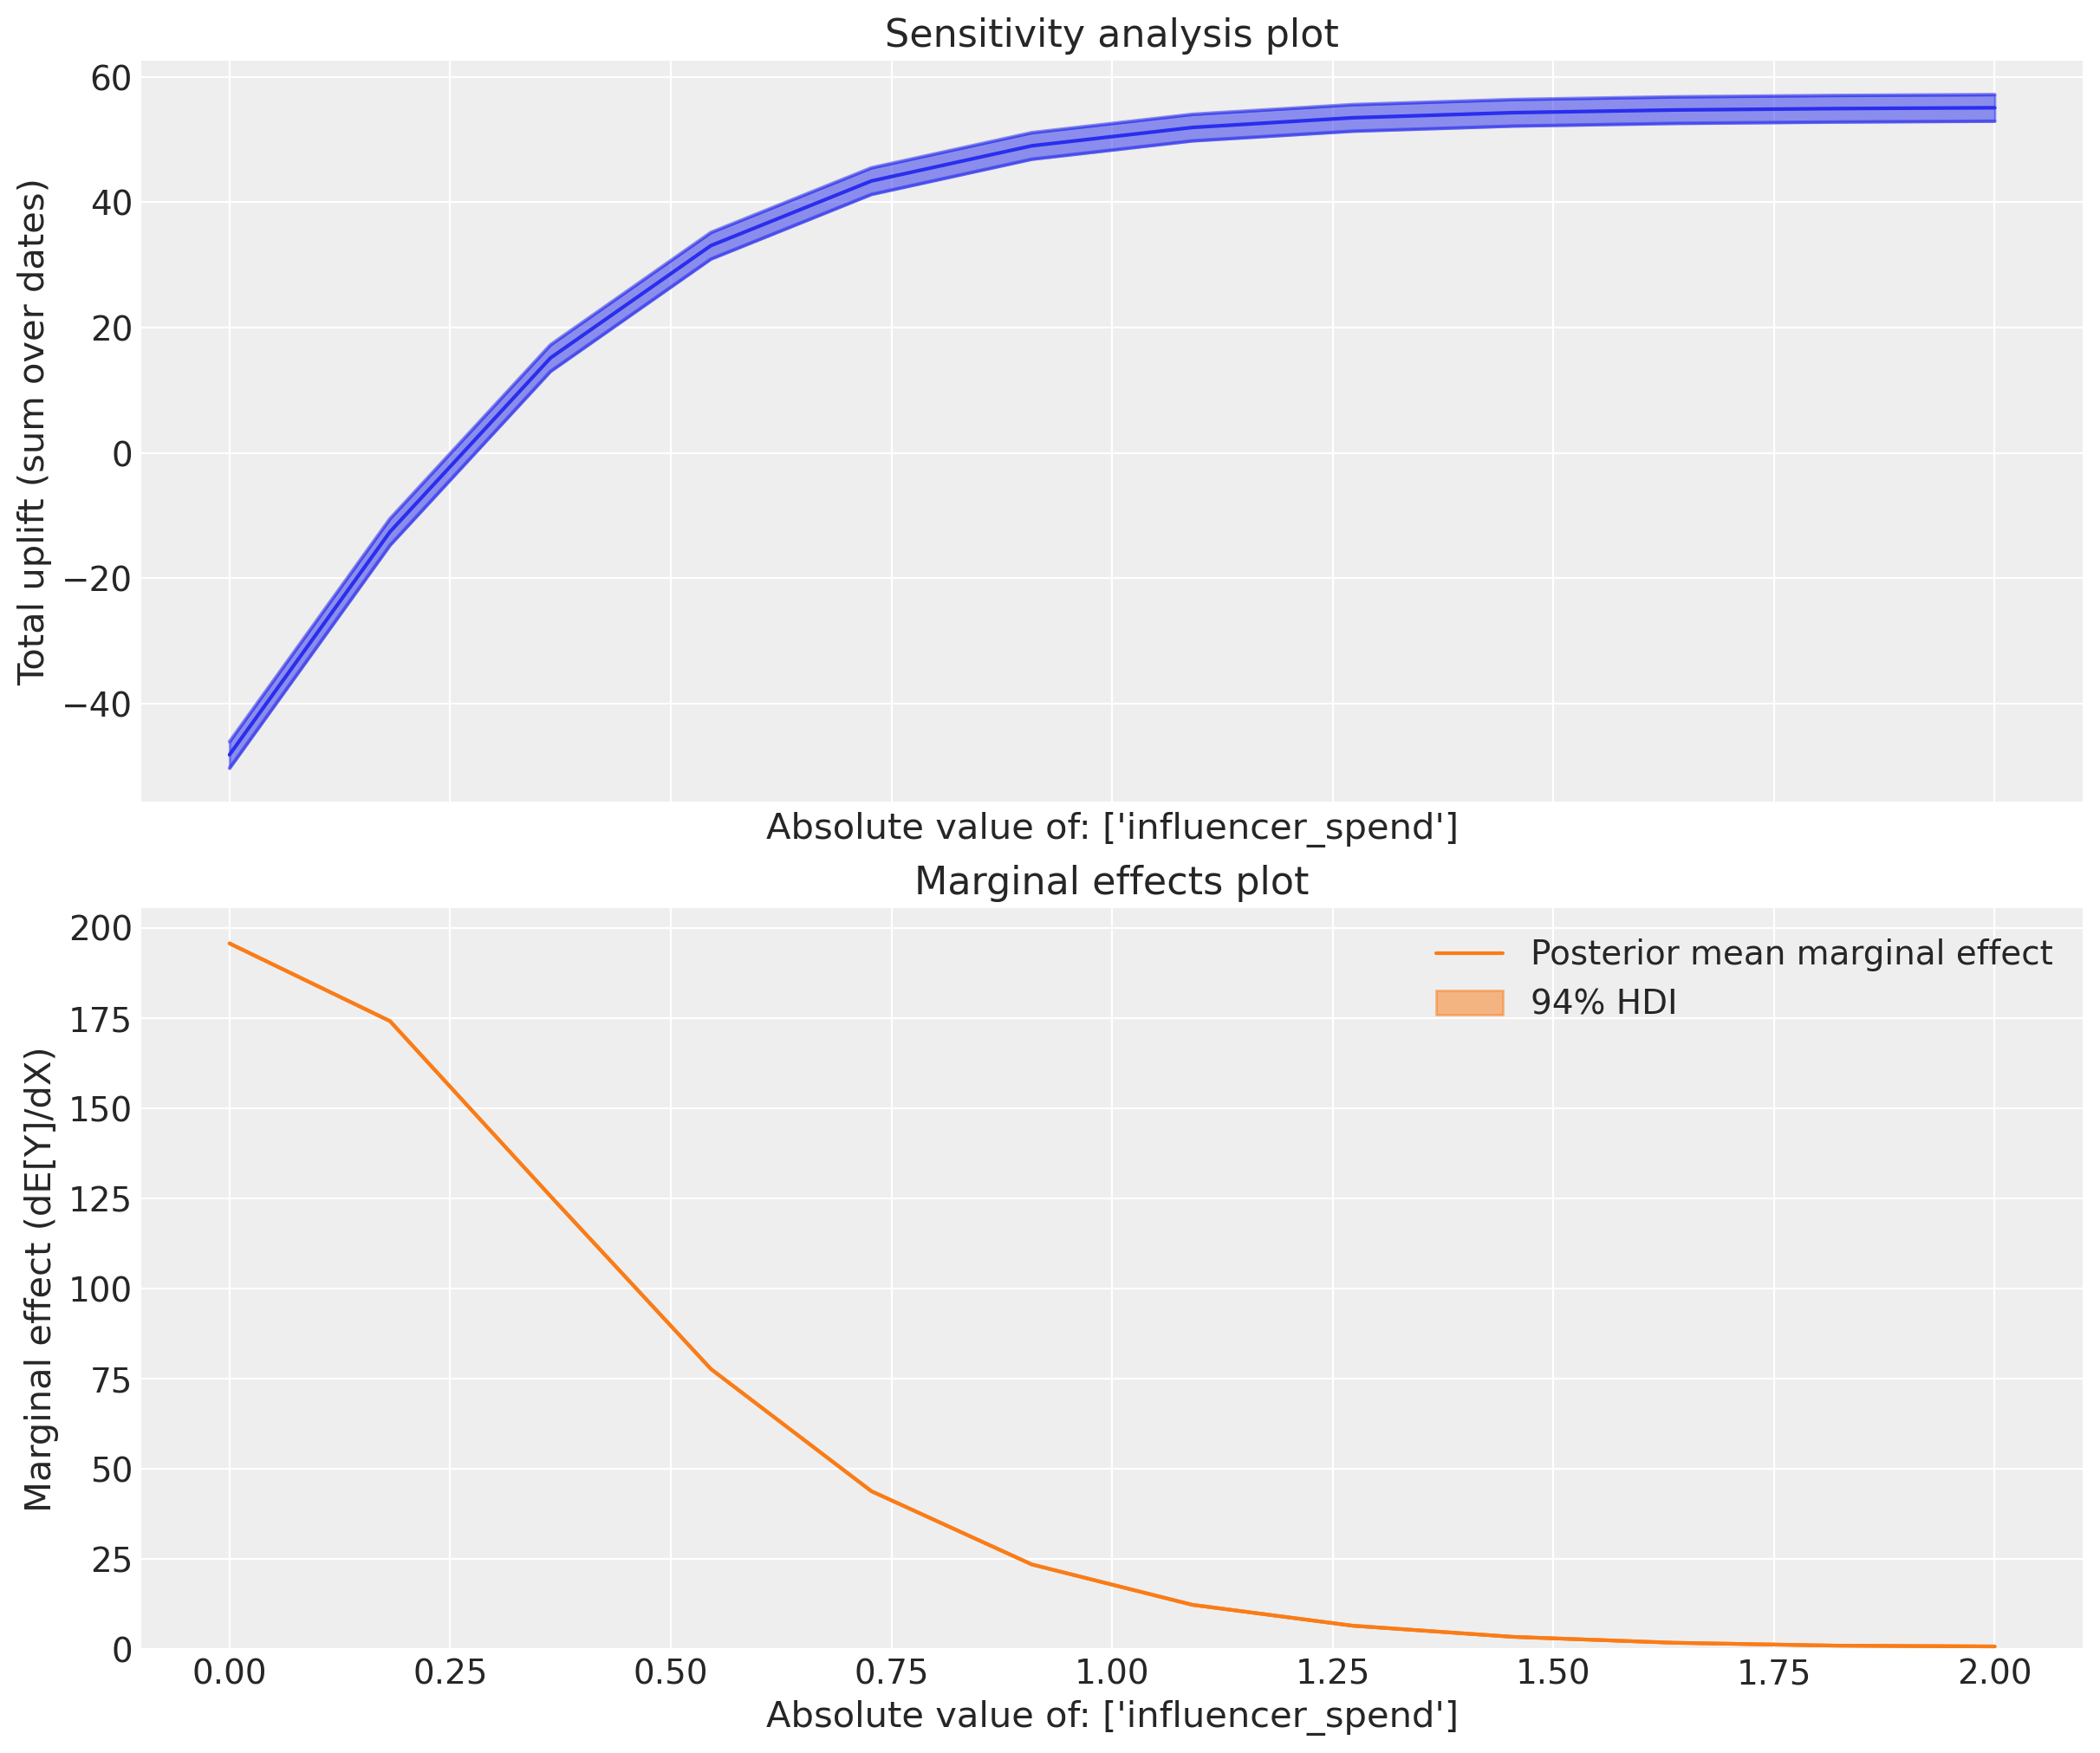

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
mmm.plot.plot_sensitivity_analysis(ax=ax[0])
mmm.plot.plot_sensitivity_analysis(marginal=True, ax=ax[1]);

The results of the absolute sweep are comparable to (but not the same as) the multiplicative sweep. They key difference in what we are doing is that we overwrite the historical influencer spend values with a constant spend value (one value for each point in the sweep). This means we are not considering a 'realistic' scenario where spend fluctuates over time, but rather a hypothetical scenario where we set the spend to a fixed value for all weeks in the dataset.

We can see the change in the plots as well. The top plot is similar to, but not exactly the same as the saturation curve of influencer spend. Notice that there is a certain fixed spend level where the uplift is about zero. This is interesting - we can interpret this as saying that the total sales in the actual scenario would also have been about the same if we had spent that amount (constantly over time) on influencer marketing.

The top plot nicely shows the saturating quality of the saturation function, and the bottom plot shows that as we approach saturation, the marginal effects drop to near zero.

### An additive sweep on influencer spend

We can also consider a sweep of additive changes to the influencer spend variable. This means we adjust the historical values of the influencer spend by adding a fixed amount (given in the `sweep_values` argument) and then compute the expected outcome and marginal effects.

:::{warning}
Note that care needs to be taken with an additive sweep. It would be easy to apply a negative peterbation which then actually results in negative spend values which have no meaningful interpretation. So it is worthwhile exploring the actual spend values before deciding on the sweep values to be used.

In our case, the minimum spend values is \$0, so we will not considervalues in the sweep.

**NOTE: WE CAN OF COURSE SET A FLOOR IN THE CODE WHICH IMPLEMENTS THE ADDITIVE SWEEP CHANGES IF WE THOUGHT THAT WAS A GOOD IDEA.**
:::

In [13]:
df["influencer_spend"].min()

In [14]:
mmm.sensitivity_analysis(
    predictors=["influencer_spend"],
    sweep_values=np.arange(0, 2, 0.25),
    sweep_type="additive",
)

Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]


/Users/benjamv/mambaforge/envs/pymc-marketing-dev/lib/python3.10/site-packages/pymc_marketing/mmm/plot.py:1017: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


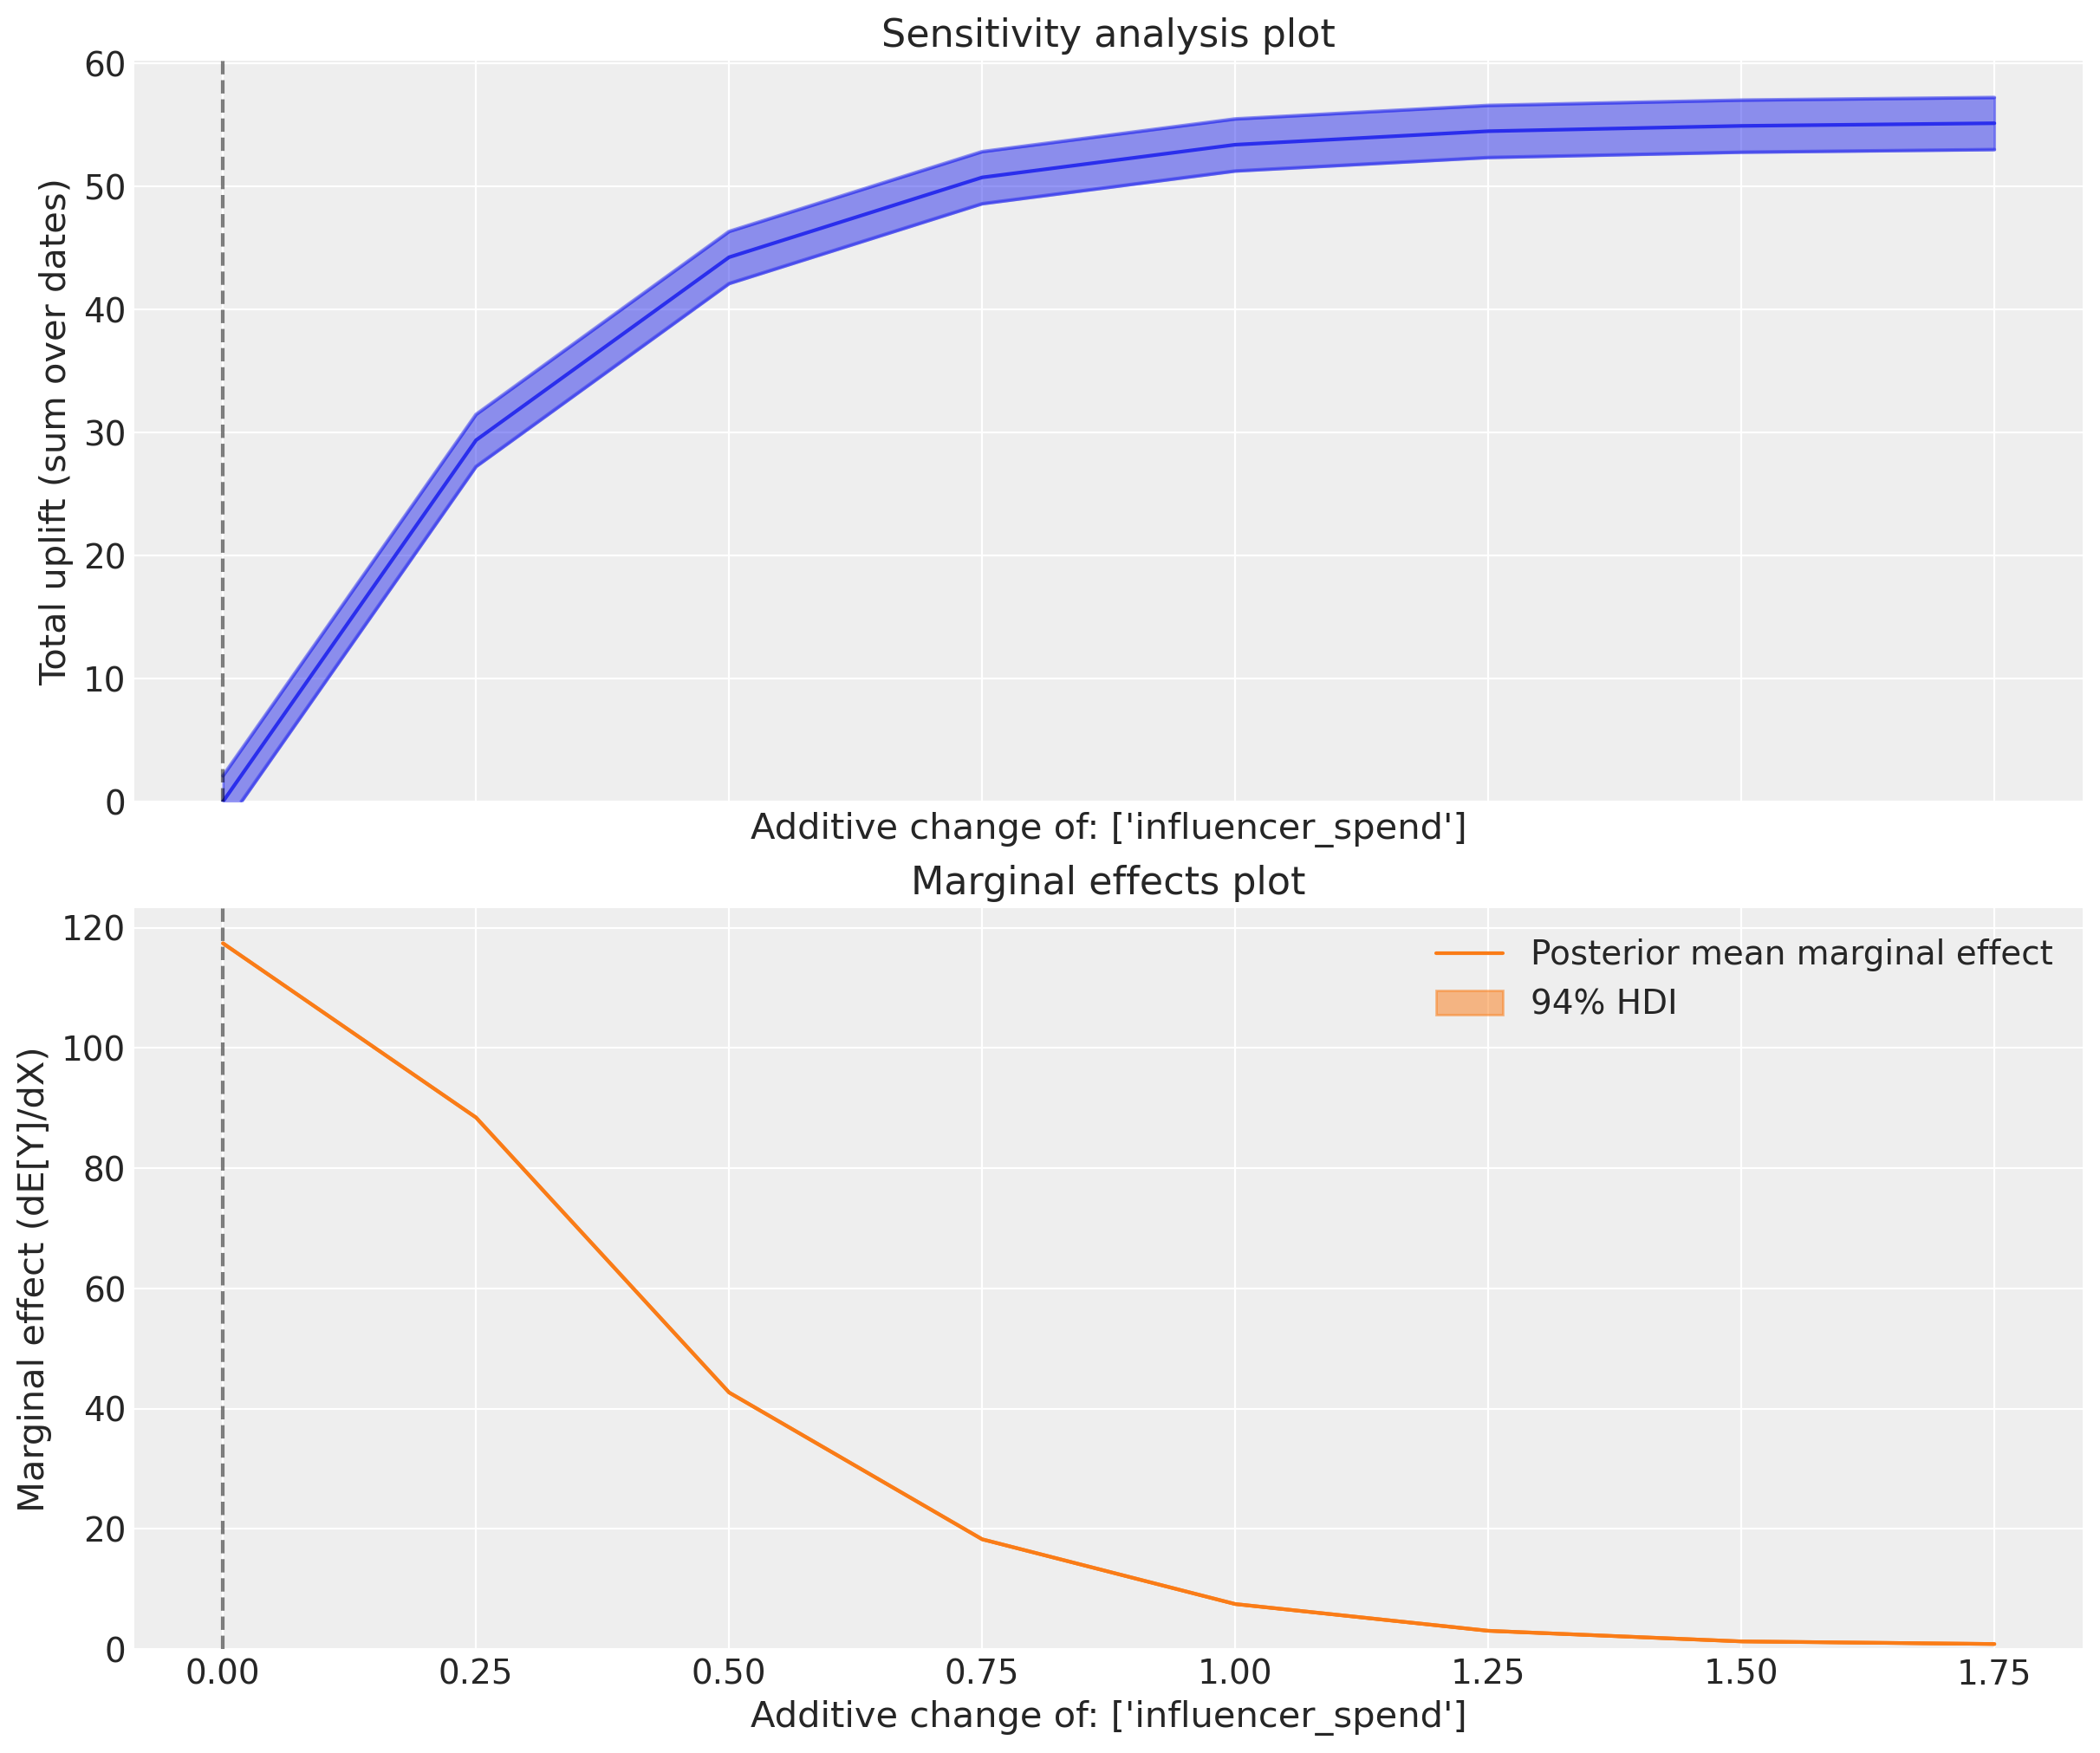

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
mmm.plot.plot_sensitivity_analysis(ax=ax[0])
mmm.plot.plot_sensitivity_analysis(marginal=True, ax=ax[1]);

These plots show the expected uplift and marginal effects. We get a similar general pattern of results - if we consider scenarios where we had spend progressively more, then we would get positive uplift, but as we reach a certain level of spend, the advertising channel saturates and the marginal effects drop to near zero.

### Sensitivity analysis on the free shipping threshold

We've had a thorough look at the influencer spend variable and we've got some interesting insights into how it affects the outcome (sales) under different counterfactual scenarios.

But we can also do the same for the free shipping threshold driver. The reason why this is interesting in our example is because this driver is assumed to have linear effects on the outcome, with no saturation or adstock function applied.

We won't exhaustively run through all the different sweeps we can do, but we will just demonstrate an absolute sweep.

In [16]:
mmm.sensitivity_analysis(
    predictors=["shipping_threshold"],
    sweep_values=np.arange(0, 30, 2),
    sweep_type="absolute",
)

Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]


/Users/benjamv/mambaforge/envs/pymc-marketing-dev/lib/python3.10/site-packages/pymc_marketing/mmm/plot.py:1017: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


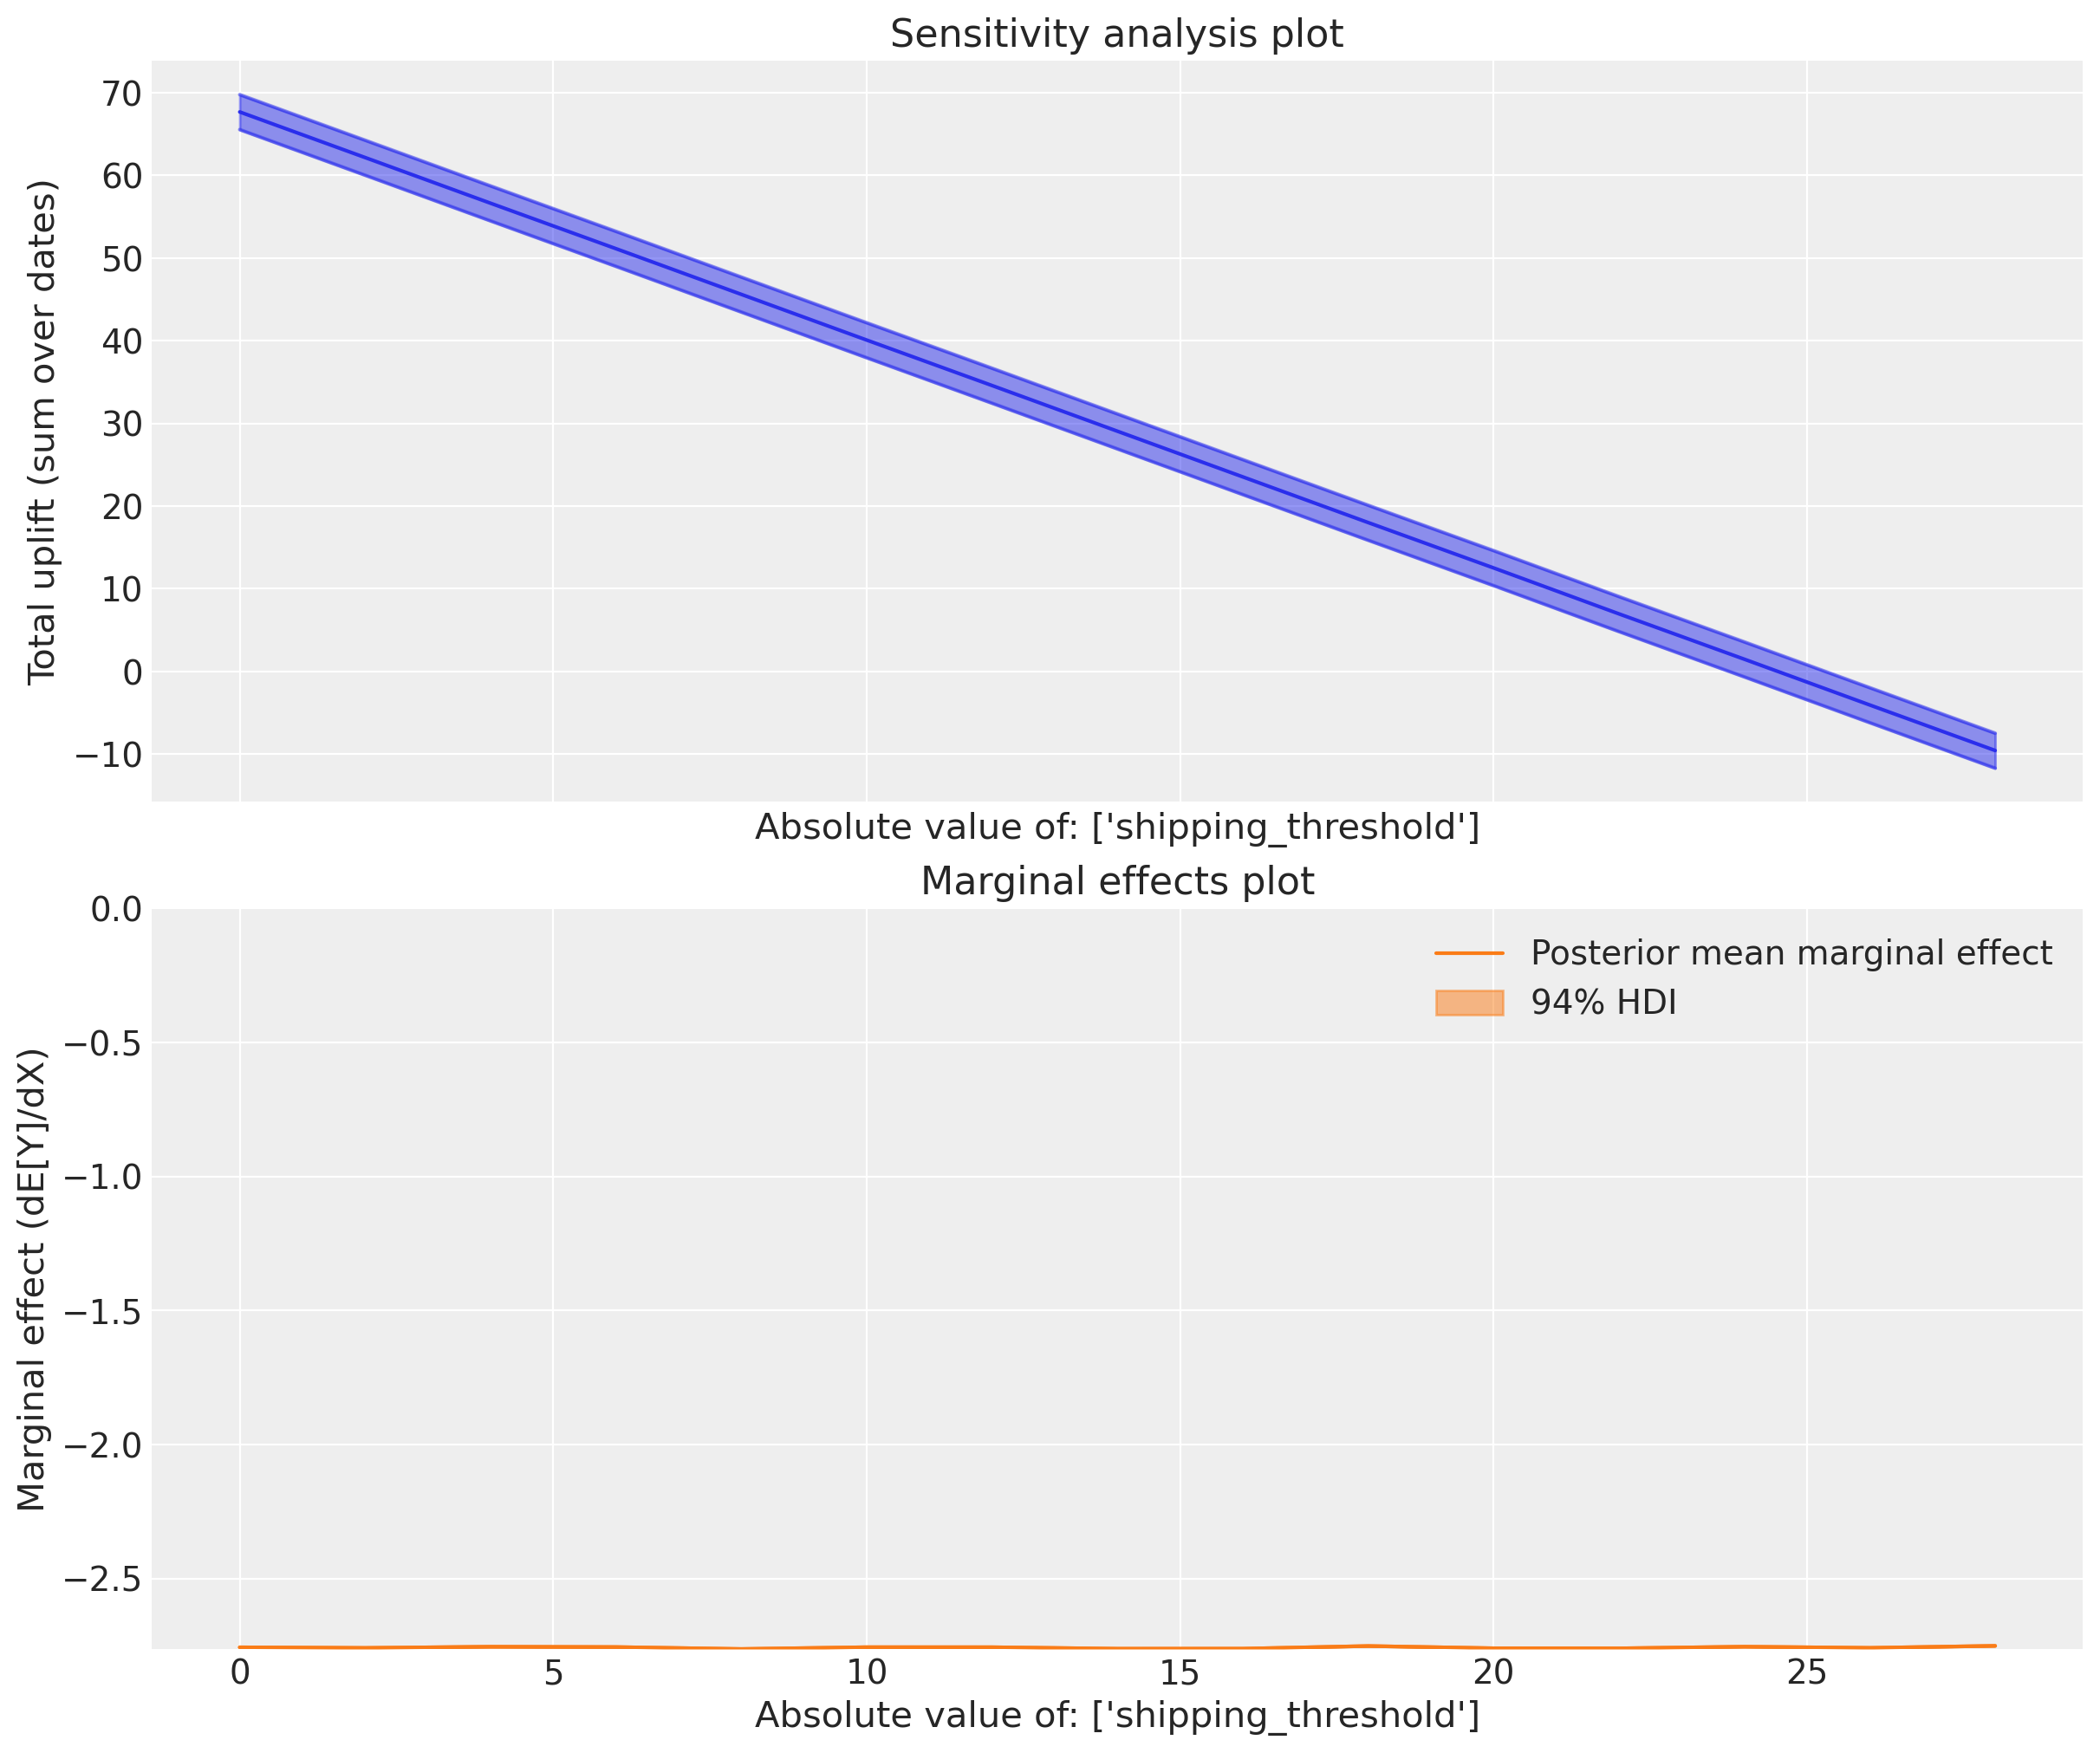

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
mmm.plot.plot_sensitivity_analysis(ax=ax[0])
mmm.plot.plot_sensitivity_analysis(marginal=True, ax=ax[1]);

We can see the linear nature of the effects of the free shipping threshold on the outcome variable. The expected uplift is positive when we lower the threshold (people buy more when shipping is free), and the marginal effects are constant across the sweep values. This is because we assumed a linear relationship between the free shipping threshold and sales, so the marginal effect does not change as we adjust the threshold. The constant negative value is equal to the change in uplift as we increase the shipping threshold by \$1. 

We can verify this by changing the sweep step size and seeing that we get identical marginal effects estimates.

In [18]:
mmm.sensitivity_analysis(
    predictors=["shipping_threshold"],
    sweep_values=np.arange(0, 30, 1),
    sweep_type="absolute",
)

Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]


/Users/benjamv/mambaforge/envs/pymc-marketing-dev/lib/python3.10/site-packages/pymc_marketing/mmm/plot.py:1017: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


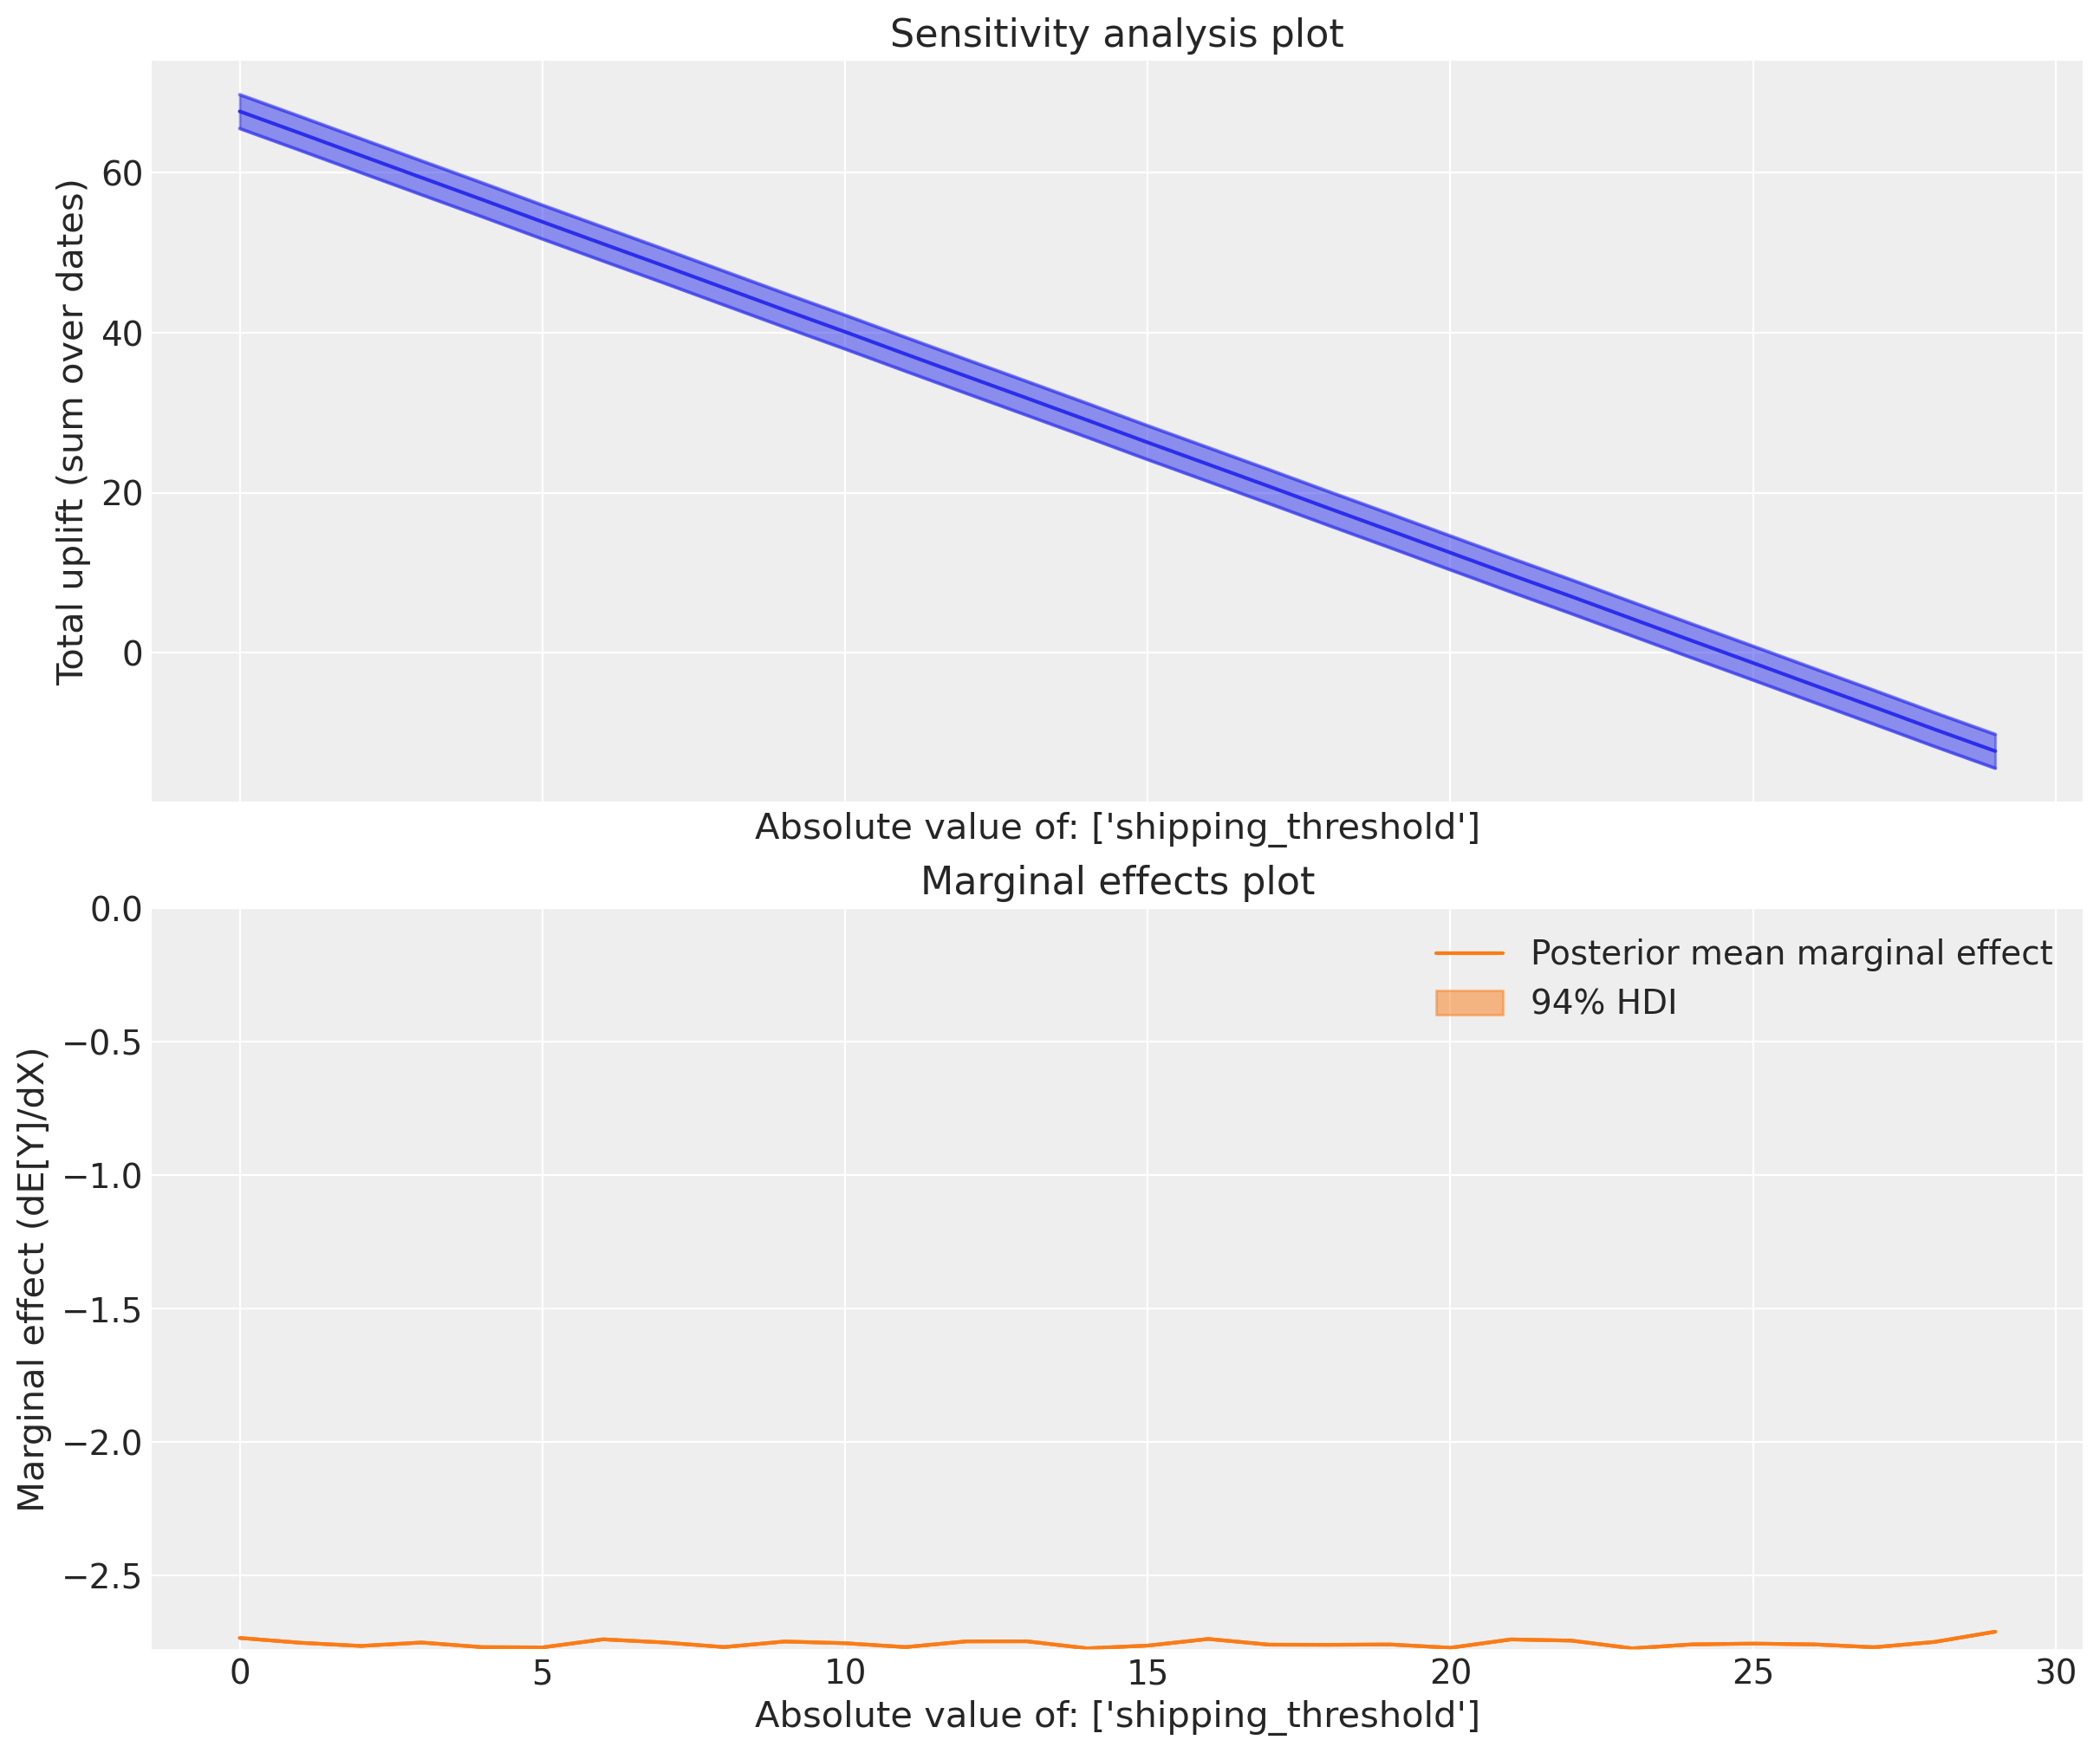

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
mmm.plot.plot_sensitivity_analysis(ax=ax[0])
mmm.plot.plot_sensitivity_analysis(marginal=True, ax=ax[1]);

:::{tip}
**Why should I be interested in a straight line and a flat line?** These are the kinds of plots that you can run through to get a sense check of whether the model is behaving as expected.

Maybe you (or a client) realises that a negative linear relationship between shipping threshold and sales is too simplistic. This can then drive model iteration and improvement - you could explore alternative functional forms for example.
:::

## Summary

We've introduced a simple but powerful tool for probing deeper into your MMM results. You can explore a sweep of perterbations to one or more driver variables and compute the expected outcomes and marginal effects for each scenario. You can consider different forms of peterbation, here we've shown multiplicative, absolute and additive sweeps.

This allows you to answer "what if" questions with precision and clarity, providing actionable insights into how different levers affect your business outcomes. You can produce simple and interpretable plots that you can use to communicate how the model works and get sense-checks on the model's behaviour and assumptions.

##

In [20]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc_marketing,pytensor

Last updated: Mon Jun 02 2025

Python implementation: CPython
Python version       : 3.10.17
IPython version      : 8.36.0

pymc_marketing: 0.14.0
pytensor      : 2.30.3

graphviz      : 0.20.3
pymc_marketing: 0.14.0
matplotlib    : 3.10.1
arviz         : 0.21.0
pandas        : 2.2.3
numpy         : 1.26.4

Watermark: 2.5.0

